/tmp/ipykernel_41569/1111784718.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")


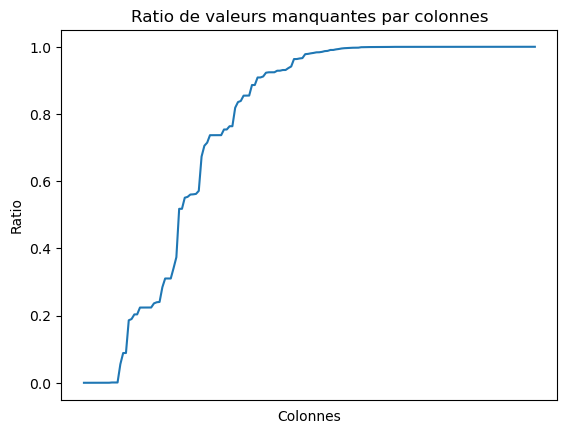

Sur tout le dataset, on a un taux de valeurs manquantes qui équivaut à 76.22 %.
Sur 162 colonnes, il y en a 16 qui n'ont aucune valeurs
Les colonnes qui n'ont aucune valeurs sont les suivantes :
['no_nutriments' 'ingredients_from_palm_oil'
 'ingredients_that_may_be_from_palm_oil' 'nutrition_grade_uk'
 'butyric-acid_100g' 'caproic-acid_100g' 'lignoceric-acid_100g'
 'cerotic-acid_100g' 'melissic-acid_100g' 'elaidic-acid_100g'
 'mead-acid_100g' 'erucic-acid_100g' 'nervonic-acid_100g'
 'chlorophyl_100g' 'glycemic-index_100g' 'water-hardness_100g']
Après conservation des données utiles au projet, il n'y a plus que 35.18 % de valeurs manquantes.
Il y a 38739 generic_names sur 320773 qui sont considérés comme valide, soit 12.08 %
Il y a 83 lignes pour lesquelles il existe un generic_name valide mais pas de product_name valide


/home/alan/miniconda3/envs/oc/lib/python3.10/site-packages/pandas/core/indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


Il y a 30.96 % de valeurs de nutri-score non définies
Il y a 100.00 % de valeurs définies pour fat_100g
Avec valeurs abbérantes


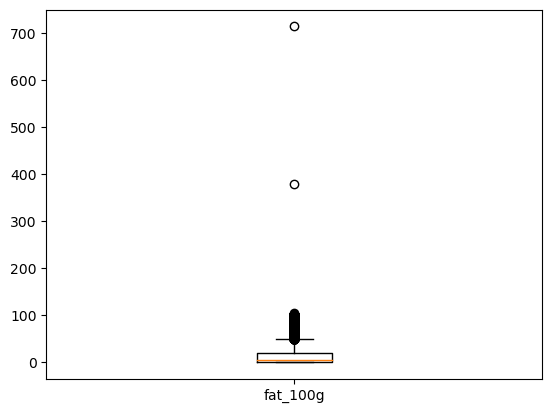

Sans valeurs abbérantes


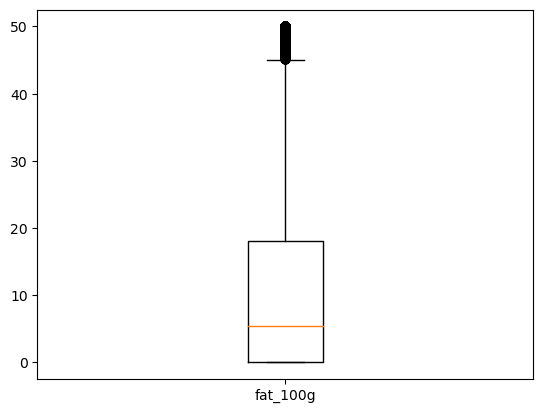

Il y a 100.0 % de valeurs définies pour fat_100g


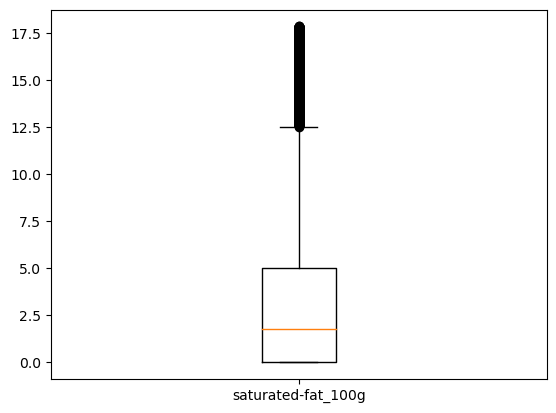

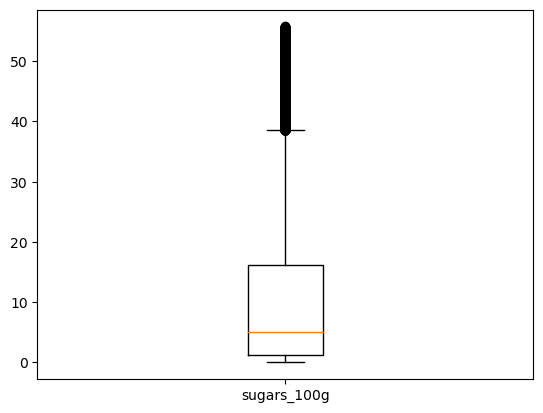

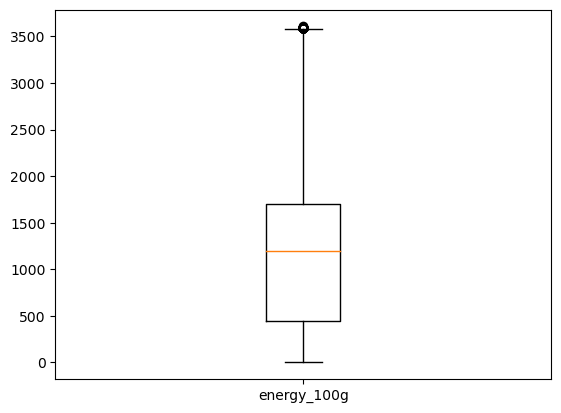

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition, preprocessing
from scipy import stats

pd.options.display.float_format = '{:.2f}'.format

%run ./nettoyage.ipynb

In [2]:
# Permet de dire que la variable `data` est du type `pd.DataFrame`
data:pd.DataFrame

# Analyse simple

In [3]:
# Afin d'avoir un apperçu de nos données nettoyées
data.describe()

,nutri_score_int,additives_n,fat_100g,saturated-fat_100g,energy_100g,sugars_100g
count,221061.00,196065.00,221061.00,221061.00,221061.00,221061.00
mean,9.17,1.98,10.64,3.31,1168.45,11.25
std,9.06,2.53,12.62,4.34,749.05,14.25
min,-15.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,450.00,1.27
50%,10.00,1.00,5.36,1.79,1192.00,5.00
75%,16.00,3.00,18.00,5.00,1703.00,16.20
max,40.00,31.00,50.00,17.84,3607.00,55.77


In [4]:
# On split et étend nos lignes pour qu'il y ai un lien unique entre la donnée et le pays.
data.loc[:,"countries"] = data['countries'].str.split(',')
data = data.explode("countries")

In [5]:
# Après augmentation de lignes
data.describe()

,nutri_score_int,additives_n,fat_100g,saturated-fat_100g,energy_100g,sugars_100g
count,225489.00,199842.00,225489.00,225489.00,225489.00,225489.00
mean,9.20,1.98,10.69,3.32,1170.65,11.31
std,9.07,2.52,12.64,4.35,750.45,14.30
min,-15.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,450.00,1.30
50%,10.00,1.00,5.36,1.79,1192.00,5.00
75%,16.00,3.00,18.18,5.00,1711.00,16.47
max,40.00,31.00,50.00,17.84,3607.00,55.77


# Analyse Univariée

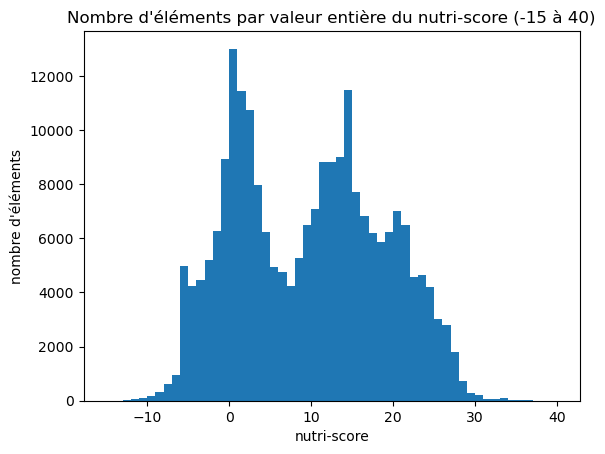

In [6]:
plt.title("Nombre d'éléments par valeur entière du nutri-score (-15 à 40)")

plt.xlabel("nutri-score")
plt.ylabel("nombre d'éléments")

plt.hist(x=data["nutri_score_int"], bins=range(-15, 41))

plt.show()

On remarque que la majorité des données du nutri-score sont soit proche de 0 ou de 15 d'après les 2 pics visibles.
En effet il y a une forme de bosses de chameau. Les autres données sont réparties autour des 2 bosses.

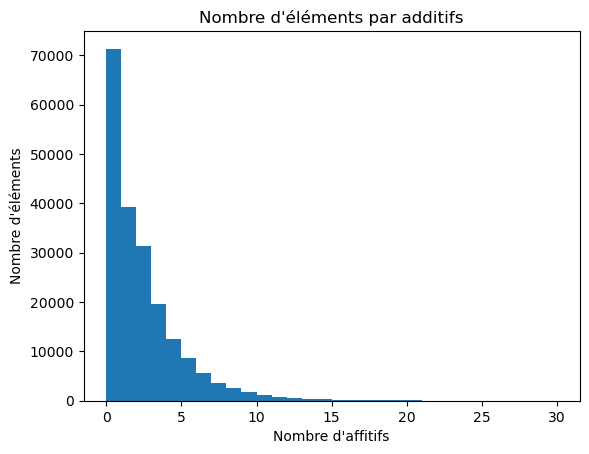

In [7]:
plt.title("Nombre d'éléments par additifs")

plt.xlabel("Nombre d'affitifs")
plt.ylabel("Nombre d'éléments")

xMin = int(min(data["additives_n"]))
xMax = int(max(data["additives_n"]))

plt.hist(x=data["additives_n"], bins=range(xMin, xMax))

plt.show()


La majorité des produits ne contiennent pas d'additifs. Il semblerait qu'à partir du nombre d'affitifs on puisse retrouver à peu près combien d'éléments avec le même nombre d'additifs existent.
Cela peut sûrement se calculer avec une fonction quadratique ou 1/x par exemple.

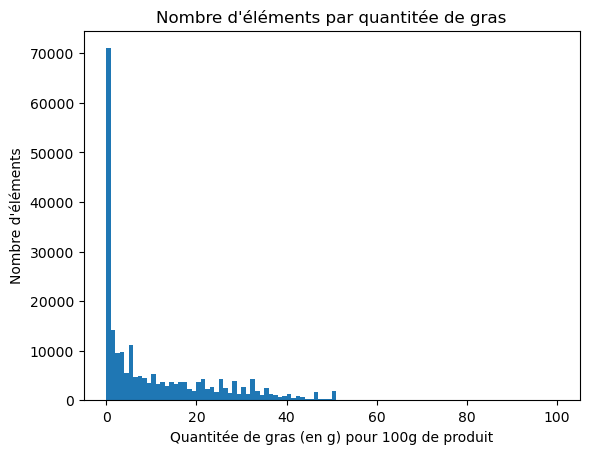

In [8]:
plt.title("Nombre d'éléments par quantitée de gras")

plt.xlabel("Quantitée de gras (en g) pour 100g de produit")
plt.ylabel("Nombre d'éléments")

plt.hist(x=data["fat_100g"], bins=range(0, 101))

plt.show()

Aucune forme de logique sur les données pour le nombre d'éléments par quantitée de gras. On remarque simplement une grosse concentration des données entre 0 et 40, mais encore les pics vers 0g et 13g pour 100g de produit.

# Analyse Bivariée

Text(0.5, 0, 'Quantitée de gras (en g) pour 100g de produit (privé de 0)')

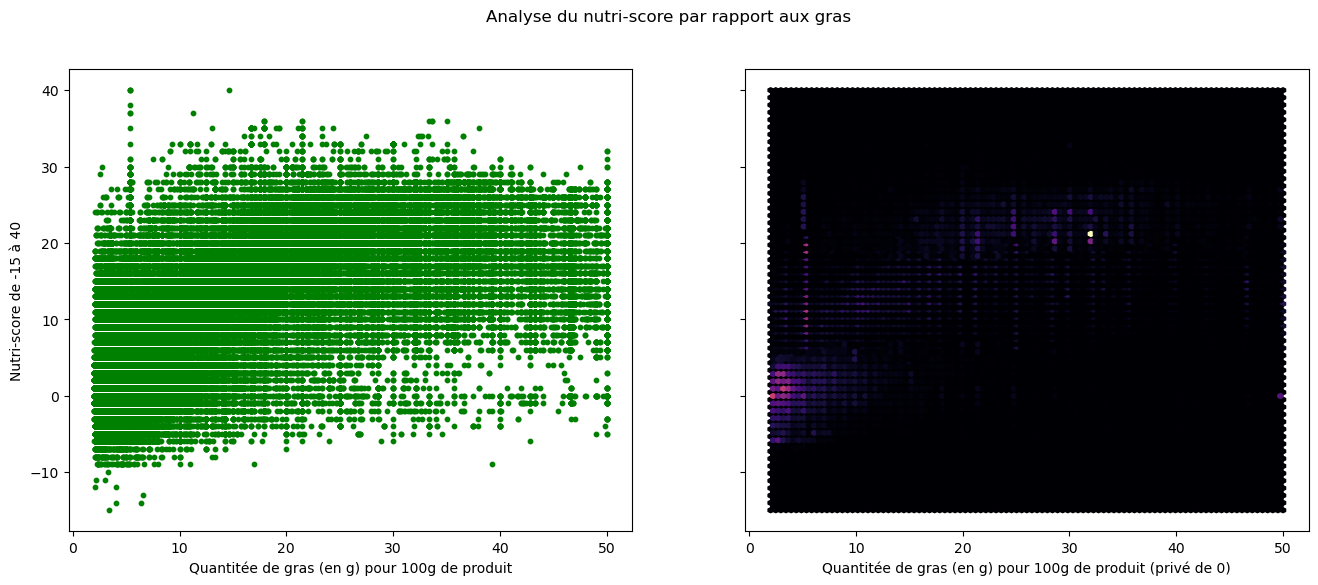

In [32]:

xLabel = "Quantité de gras (en g) pour 100g de produit"
yLabel = "Nutri-score de -15 à 40"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=True)

fig.suptitle("Analyse du nutri-score par rapport aux gras")

# On exclu quelques valeurs au deçu de 0 car on ne pourra pas voir le poids des autres valeurs
without_fat_0 = data.loc[data["fat_100g"] > 2]

ax1.scatter(x=without_fat_0["fat_100g"], y=without_fat_0["nutri_score_int"], c="g", s=10)
ax1.set_xlabel(xLabel)
ax1.set_ylabel(yLabel)


ax2.hexbin(x=without_fat_0["fat_100g"], y=without_fat_0["nutri_score_int"], cmap="magma")
ax2.set_xlabel(f"{xLabel} (privé de 0)")

Il y a une grosse répartition des données autout de 0. On peut interpréter cela moins il y a de gras, plus le nutri-score aura tendance à être négatif (proche de A). À l'inverse, plus il y a de gras, plus le nutri-score a tendance à augmenter.

In [10]:
numerics = data.select_dtypes(include=np.number)
correlations = numerics.corr(method='pearson').round(2)
correlations

,nutri_score_int,additives_n,fat_100g,saturated-fat_100g,energy_100g,sugars_100g
nutri_score_int,1.00,0.17,0.58,0.61,0.64,0.45
additives_n,0.17,1.00,-0.04,0.08,0.02,0.15
fat_100g,0.58,-0.04,1.00,0.53,0.63,0.20
saturated-fat_100g,0.61,0.08,0.53,1.00,0.47,0.23
energy_100g,0.64,0.02,0.63,0.47,1.00,0.33
sugars_100g,0.45,0.15,0.20,0.23,0.33,1.00


<AxesSubplot:title={'center':'Matrice de corrélation'}>

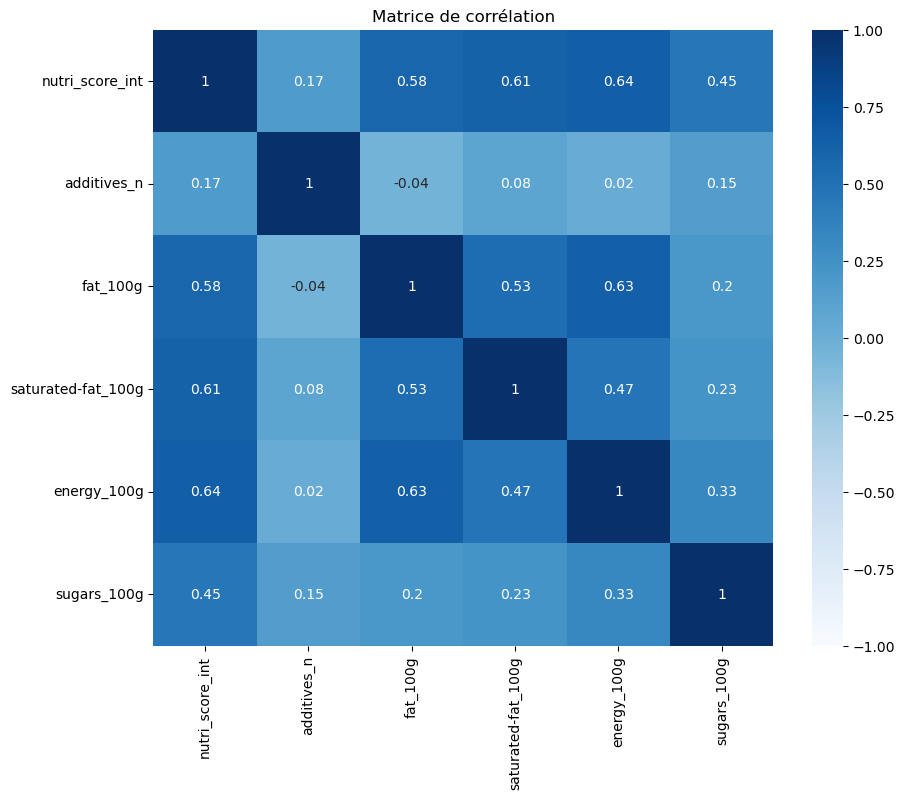

In [11]:

cols = len(numerics.columns)
fig, ax = plt.subplots(figsize=(10,8))

plt.title("Matrice de corrélation")
sns.heatmap(correlations, annot=True, cmap="Blues", vmin=-1, vmax=1)

On remarque une possible corrélation linéaire entre nutri-score / fat_100g ; nutri-score / saturated-fat_100g ; fat_100g / saturated-fat_100g.

In [12]:
numerics.replace(np.NaN, 0, inplace=True)

# ACP

In [13]:
numerics.columns

Index(['nutri_score_int', 'additives_n', 'fat_100g', 'saturated-fat_100g',
       'energy_100g', 'sugars_100g'],
      dtype='object')

In [14]:
n = len(numerics.columns) - 1
X_scaled = preprocessing.StandardScaler().fit_transform(numerics)
pca = decomposition.PCA(n_components=n)
X_projected = pca.fit_transform(X_scaled)
pcs = pd.DataFrame(X_projected, index=numerics.index, columns=["F"+str(i+1) for i in range(n)])
pcs

,F1,F2,F3,F4,F5
0,1.46,-1.01,-0.32,-1.32,0.15
1,-0.02,-0.71,-0.77,-1.29,0.31
2,0.82,-1.02,0.04,-0.36,-1.55
3,0.83,-0.14,0.04,-0.46,0.16
4,1.76,-1.23,0.85,-1.12,0.49
...,...,...,...,...,...
221056,-1.36,-0.72,-0.24,-0.58,-0.66
221057,-1.25,-0.84,-0.15,-0.70,-0.50
221058,-0.30,-0.94,-0.12,-0.55,-1.33
221059,-2.13,-0.47,-0.08,0.49,0.25


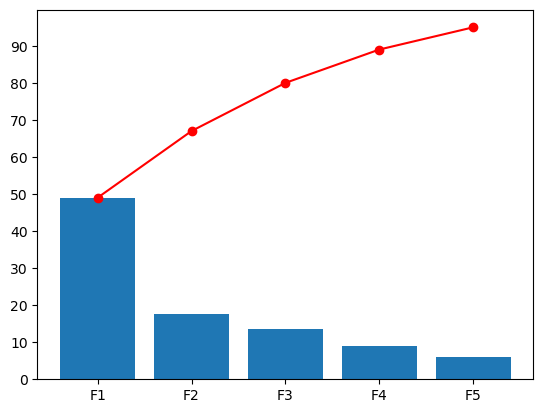

In [15]:
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()

n_list = range(1,n+1)

plt.xticks(ticks=n_list, labels=map(lambda x: f"F{x}" ,n_list))
plt.yticks(ticks=range(0, 100, 10))
plt.bar(n_list, scree)
plt.plot(n_list, scree_cum, c="r", marker="o")

plt.show()

In [16]:
# Fonction récupérée du cours P2C6-TP-cours-effectuees
def pca_circle(pca,x,y):
    fig, ax = plt.subplots(figsize=(9, 8))
    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0,
                0,  # Start the arrow at the origin
                pca.components_[x, i],  #0 for PC1
                pca.components_[y, i],  #1 for PC2
                head_width=0.05,
                head_length=0.03, 
                width=0.02)

        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                numerics.columns[i])

    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], c='r')
    plt.plot([0, 0], [-1, 1], c='r')


    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel(f'F{x+1} ({round(100*pca.explained_variance_ratio_[x],1)}%)')
    plt.ylabel(f'F{y+1} ({round(100*pca.explained_variance_ratio_[y],1)}%)')

    plt.title(f"Cercle des corrélations (F{x+1} et F{y+1})")
    plt.grid(True)


    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    # Repère orthonormé
    plt.axis('equal')
    plt.show()

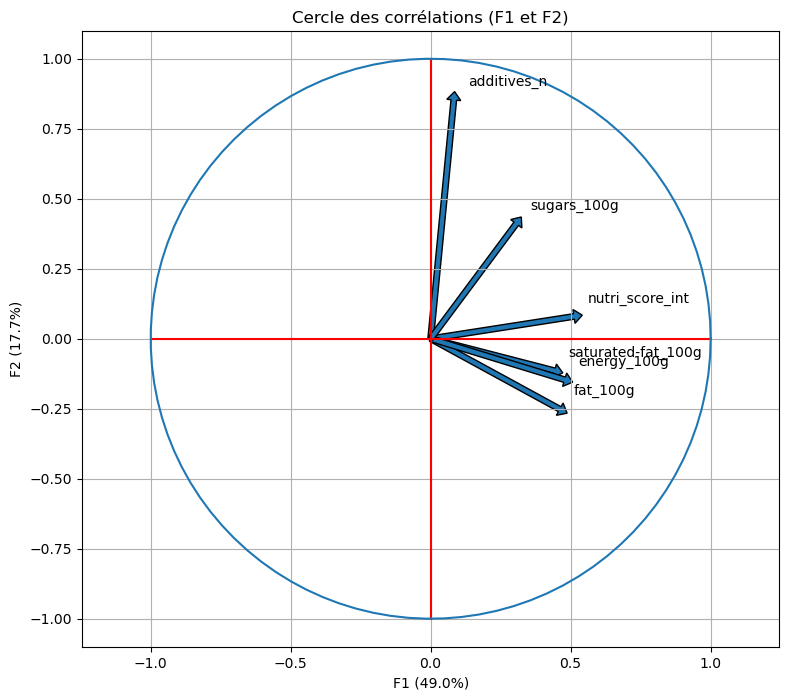

In [17]:
x, y = 0,1

pca_circle(pca, x, y)

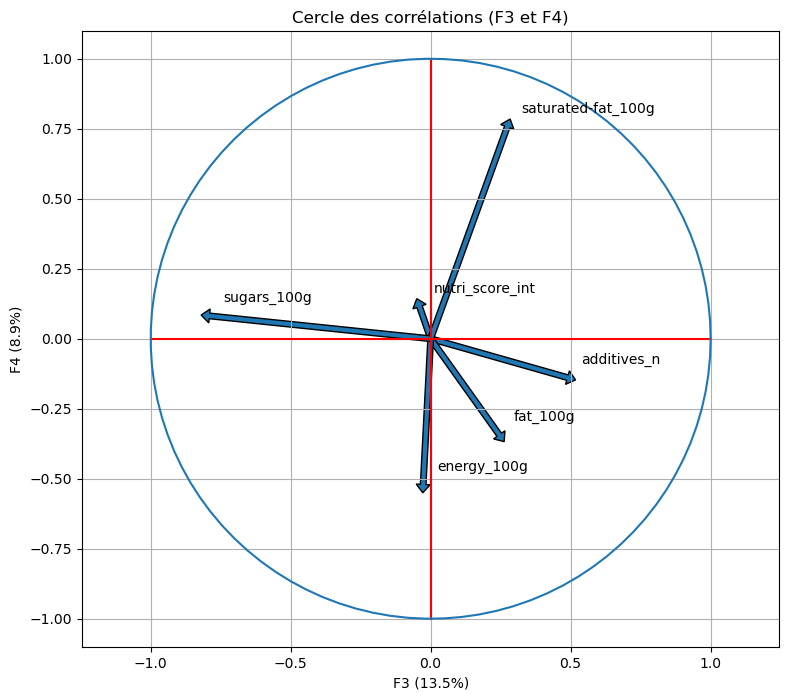

In [18]:
x,y=2,3
pca_circle(pca, x, y)

Avec l'aide du cours, on peut tracer le cercle de corrélation.

Ce cercle nous indique qu'on pourrait génraliser nos colonnes avec F1,F2 et F3. En faisant cela on perdrait approximativement 10% des informations.

# ANOVA

Cette partie n'est pas vraie. J'avais visiblement mal compris l'ANOVA.

In [19]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    

anova = []
for i,x in enumerate(numerics.columns):
    anova.append([])
    for j,y in enumerate(numerics.columns):
        r = eta_squared(numerics[x], numerics[y])
        anova[i].append(r)


<AxesSubplot:>

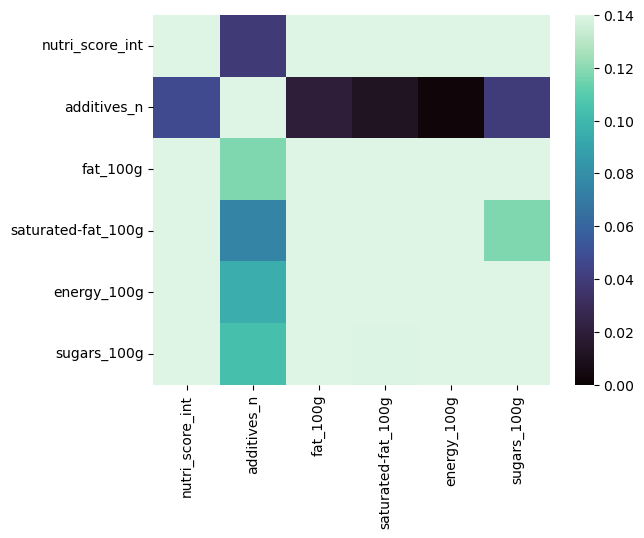

In [20]:
sns.heatmap(anova, vmin=0, vmax=0.14, xticklabels=numerics.columns, yticklabels=numerics.columns, cmap="mako")

On peut voir qu'il y a beaucoup de blanc, ce qui veut dire que beaucoup de colonnes possèdent une ou plusieurs relations entre elles

## Correction

Voici une correction de mon ANOVA que je présenterai avec ma diapo

In [21]:
nutriscores = data["nutri_score"].unique().dropna()
nutriscores

['D', 'A', 'C', 'E', 'B']
Categories (5, object): ['A' < 'B' < 'C' < 'D' < 'E']

In [22]:
nutriscore_fats = {nutriscore: data["fat_100g"][data["nutri_score"] == nutriscore] for nutriscore in nutriscores}

valid_hypothesis = []
for i, n1 in enumerate(nutriscores):
    for j,n2 in enumerate(nutriscores, i):
        if(n1 == n2):
            continue

        f,p = stats.f_oneway(nutriscore_fats[n1], nutriscore_fats[n2])
        if(p > f): valid_hypothesis.append(f"{n1} et {n2} ont des hypothèses de moyenne valides avec f={f} et p={p}")
        #print(f"Nutriscores {n1} et {n2} ont un f={f} et p={p}")

for i in valid_hypothesis:
    print(i)

f,p = stats.f_oneway(nutriscore_fats["A"], nutriscore_fats["B"], nutriscore_fats["C"], nutriscore_fats["D"], nutriscore_fats["E"])
print(f"f={f}, p={p}")

f=27495.082859826263, p=0.0


# By country

In [23]:
nutrition_by_country = data.groupby("countries")["nutri_score_int"].mean().sort_values()
nutrition_by_country

countries
Vanuatu           -0.50
Oman               0.00
Gabon              0.00
Guyana             1.00
Costa-Rica         1.00
                   ... 
Bulgarie          20.40
Egypte            20.50
Arabie Saoudite   21.83
Arménie           22.00
Pakistan          33.00
Name: nutri_score_int, Length: 94, dtype: float64

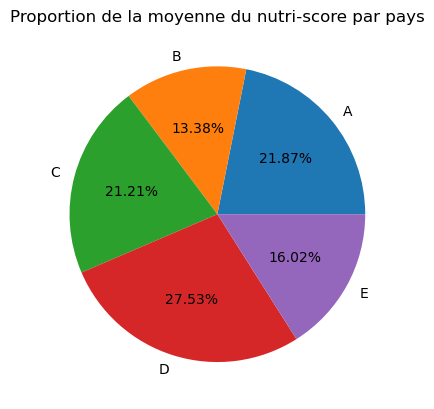

In [24]:
nutri = data["nutri_score"].value_counts().sort_index()
plt.title("Proportion de la moyenne du nutri-score par pays")
plt.pie(nutri, labels=nutri.index, autopct='%.2f%%');

# Suite

Pour la suite on peut faire un modèle de prédiction d'un pays en fonction de la préférence de nourriture d'une personne. En effet un personne peut avoir une nutrition très variée.
Il suffirait d'analyser la variance du nutriscore des aliments que la personne consomme et de comparer cela à la variance du nutriscore de la nourriture d'une pays.